In [6]:
import os
import sys
import glob
import math
import random
import numpy as np
import argparse
import configparser
from pathlib import Path
from tqdm import trange, tqdm
from datetime import datetime

from scipy import interpolate
from scipy.interpolate.interpnd import _ndim_coords_from_arrays
from scipy.spatial import cKDTree

from astropy import units as u
from astropy import constants
from astropy import constants

from astropy.io import fits
from astropy.io.fits import Header
from astropy.table import Table
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import Galactic

from pybaselines import Baseline
import matplotlib.pyplot as plt

from gustoL09P.GL09PDataIO import loadL08Data

#output_filename = '/Volumes/GUSTO/integrated-G345a-%s.csv' % datetime.today().strftime('%Y-%m-%d')
#output_stream = open(output_filename,"a")
#directory = '/Volumes/GUSTO/Data/level1.0/'
directory = '/Volumes/GUSTO/Data/level0.9-method4rfs'
#lineout = "SERIES,LINEFREQ,GLON,GLAT,SCANDIR,TARMS,MIXER,VN150,VN140,VN130,VN120,VN110,VN100,VN090,VN080,VN070,VN060,VN050,VN040,VN030,VN020,VN010,VP000,VP010,VP020,VP030,VP040,VP050,VP060,VP070,VP080,VP090,VP100\n"
#output_stream.write(lineout)

#velocity_width=10
#velocity_bins=np.arange(-150,110,velocity_width)
#baseline_size=20

#build a 3D array for regridding: axis 1: GALLONG axis 2: GALLAT axis 3: VELOCITY
#build a second 3D array for counting denominator to divide by when done
spacing = 2.0/60 # 2 arcmin spatial spacing
vel_spacing = 5 # km/s
l_start=349
l_end=353
l_vector = np.arange(l_start,l_end,spacing)
b_vector = np.arange(-1.5,1.5,spacing)
v_vector = np.arange(-250,250,vel_spacing)

l_grid, b_grid, v_grid = np.meshgrid(l_vector,b_vector,v_vector,indexing='ij')
intensity_sum = np.zeros_like(v_grid,dtype='float64')
count_sum = np.zeros_like(v_grid)

# find the closest l,b
# determine indicies to address
# compact vlsr to v_vector size
# add to temp_sump
# increment count_sum

#filenames = ["CII_10000_24038_L10.fits"]

for input_filename in tqdm(os.listdir(directory)):
    #for input_filename in filenames:
    # check that the filename ends with .fits
    ifile = os.path.join(directory,input_filename)
    dsc = int(input_filename.split('_')[2].split('.')[0])
    spec, data, hdr, hdr1 = loadL08Data(ifile, verbose=False)
    rowFlag = data['ROW_FLAG']
    n_spec, n_pix = spec.shape
    
    # compute velocity                                                           
    npix    = hdr['NPIX']            
    IF_pix  = hdr['CRPIX1']
    IF_val  = hdr['CRVAL1']
    IF_del  = 4.887586
    IF_freq = (np.arange(npix)-IF_pix)*IF_del+IF_val
    VLSR    = hdr['VLSR']        
    
    IF_vlsr0= hdr['IF0']
    line_freq = hdr['LINEFREQ']

    if line_freq < 1900500:
        continue
    
    vlsr    = (IF_vlsr0 - IF_freq)/line_freq*constants.c.value/1.e3 + VLSR # Vlsr in km/s 

    # find closest velocity in v_vector
    
    #x_vlsr = ((line_freq/T['freq'][1])-1)*299792
    
    #rms = np.zeros(n_spec)
    #basecorrf = np.zeros((n_spec,n_pix))
    #prange = [int(hdr['pgpixst']), int(hdr['pgpixen'])]
    #osel = np.argwhere((data['scan_type'] == 'OTF') & (data['ROW_FLAG']==0)).flatten()
    #osel = np.argwhere((data['scan_type'] == 'OTF') & ((data['ROW_FLAG'] & 0x60)==0) & ((data['MIXER']==5) | (data['MIXER']==8)) & (data['rms']<5)).flatten()
    osel = np.argwhere((data['scan_type'] == 'OTF') & ((data['ROW_FLAG'] & 0x60)==0) & ((data['MIXER']==5) | (data['MIXER']==8))).flatten()
    
    if len(osel) <= 0:
        print('WARNING: No OTF spectra available in ',input_filename)
        # logger.warning('No OTF spectra available.')                           
    else:
        spec_OTF = np.squeeze(spec[osel,:])
        data_OTF = np.squeeze(data[osel])
        n_OTF, n_otfpix = spec_OTF.shape
        #x=np.arange(n_otfpix)
    
        # Instantiate for ra,dec->l,b transform                                      
        c_ra_dec = SkyCoord(ra=data_OTF['RA']*u.degree, dec=data_OTF['DEC']*u.degree, frame='icrs')
    
        #basecorr = np.zeros(spec_OTF.shape)
        #rmsotf = np.zeros(n_OTF)
        #rf = np.zeros(n_OTF)
    
        # empty arrays to fill                                                        

        c_l_b = c_ra_dec.transform_to(Galactic)    # transform to l,b

        if c_l_b.l.value[0] < l_start:
            continue
        if c_l_b.l.value[0] > l_end:
            continue
        
        #if c_l_b.b.value[0] < c_l_b.b.value[n_OTF-1]:
        #    direction='P';
        #else:
        #    direction='N';
        
        #plt.clf()
        #        print('processing data ...')
        # calculate total power                                             
        for i0 in range(n_OTF):
            l_index = (l_vector >= c_l_b.l.value[i0]-spacing/2) & (l_vector < c_l_b.l.value[i0]+spacing/2)
            b_index = (b_vector >= c_l_b.b.value[i0]-spacing/2) & (b_vector < c_l_b.b.value[i0]+spacing/2)
            for idx,vel in np.ndenumerate(v_vector):
                v_index = np.abs(vlsr - vel) <= vel_spacing/2
                intensity_sum[l_index,b_index,idx] += np.ma.sum(spec_OTF[i0,v_index])
                count_sum[l_index,b_index,idx] += np.ma.count(spec_OTF[i0,v_index])

        #intensity=intensity_sum/count_sum
        #plt.clf()
        #plt.pcolormesh(l_grid[:,:,1],b_grid[:,:,1],intensity[:,:,65])
        #plt.show()
                


100%|████████████████████████████████████████████████████████████████████████████████████████▊| 10168/10184 [2:34:19<00:14,  1.10it/s]


IndexError: list index out of range

In [9]:
print(input_filename)
print(intensity_sum[intensity_sum>0])
print(count_sum[count_sum>0].shape)
print(count_sum[count_sum>0].shape)
print(c_l_b.l.value[i0])

G000
[ 14.65395963  62.66143608  24.38233626 ... 158.51940358 347.31479445
  98.35379863]
(529690,)
(529690,)


IndexError: index 777 is out of bounds for axis 0 with size 696

(120, 90, 100) (100,) (120, 90, 100) 100
350.666666666668 0.16666666666667185


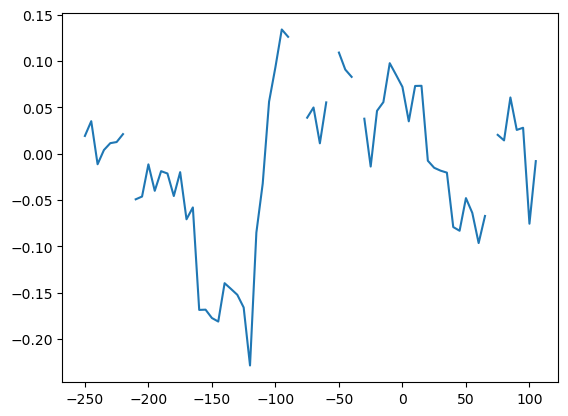

0 -250


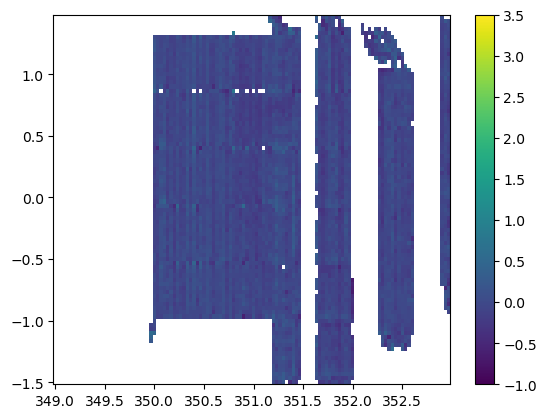

1 -245


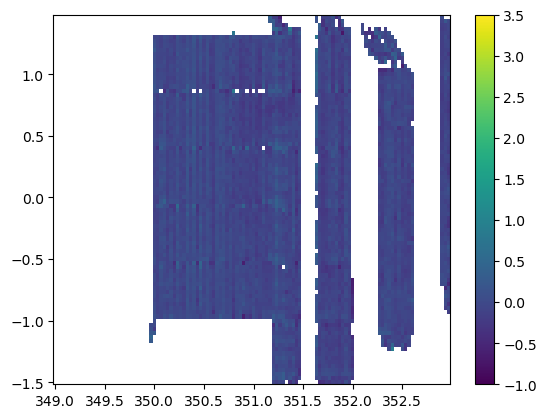

2 -240


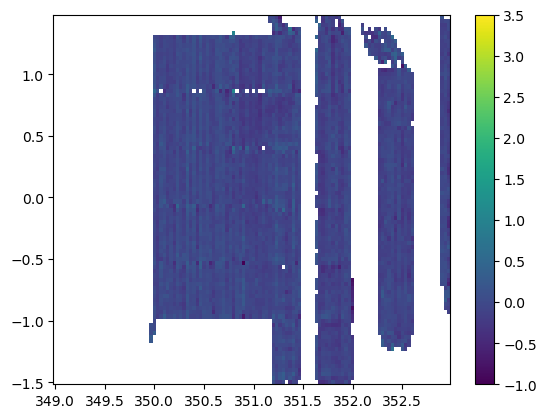

3 -235


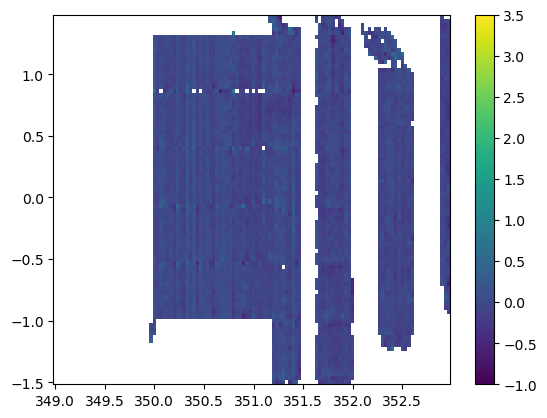

4 -230


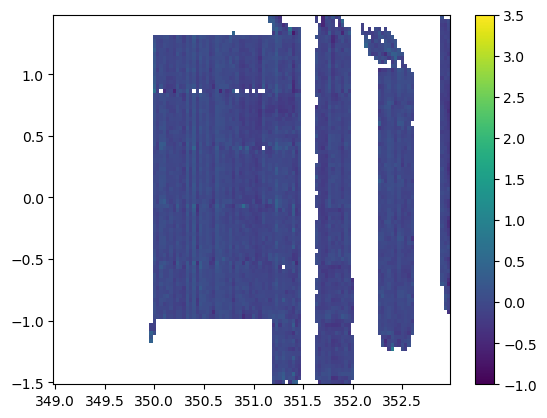

5 -225


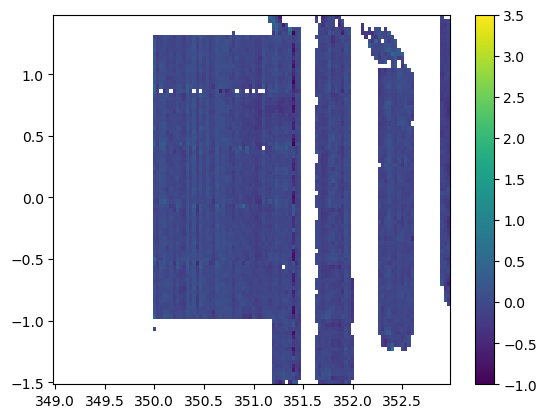

6 -220


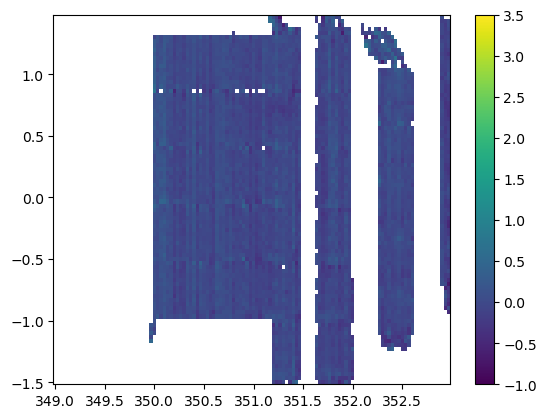

7 -215


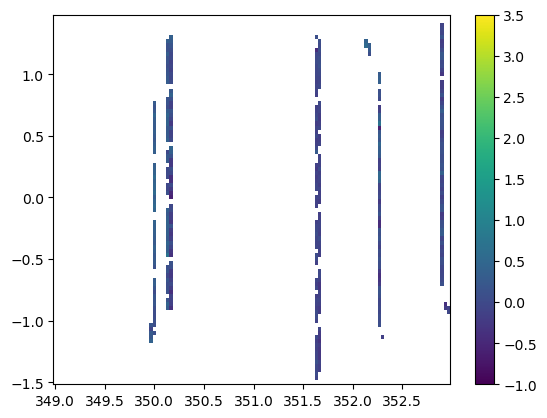

8 -210


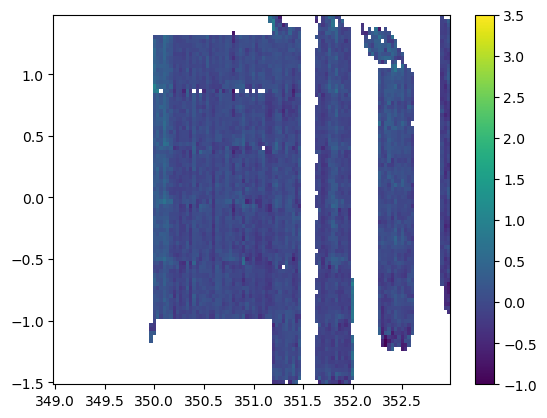

9 -205


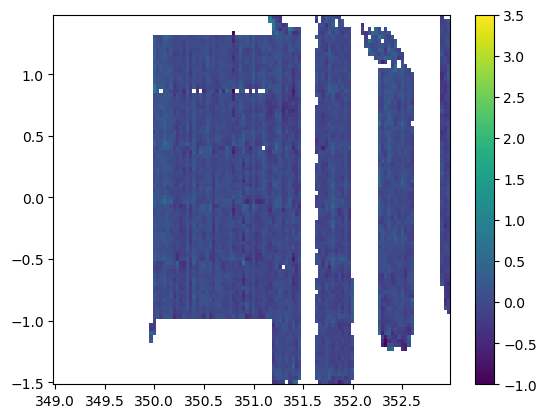

10 -200


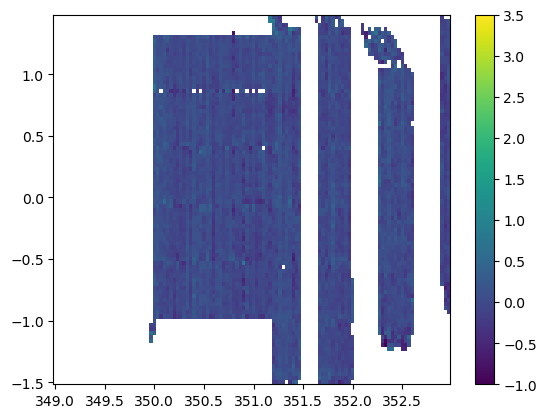

11 -195


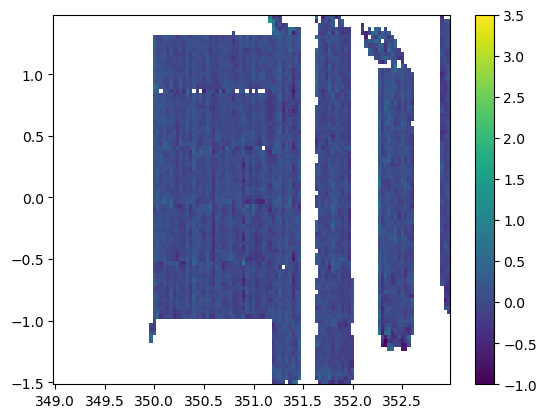

12 -190


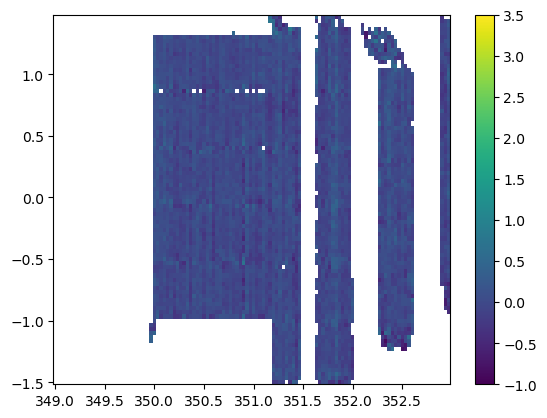

13 -185


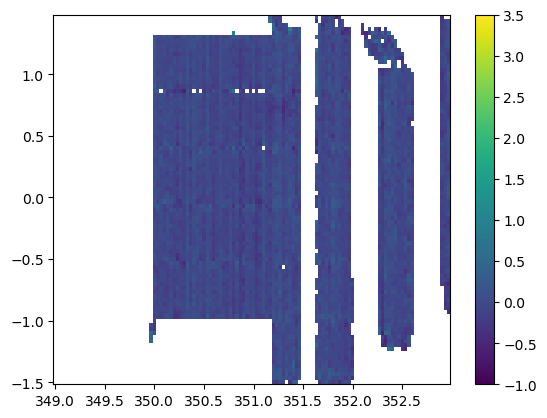

14 -180


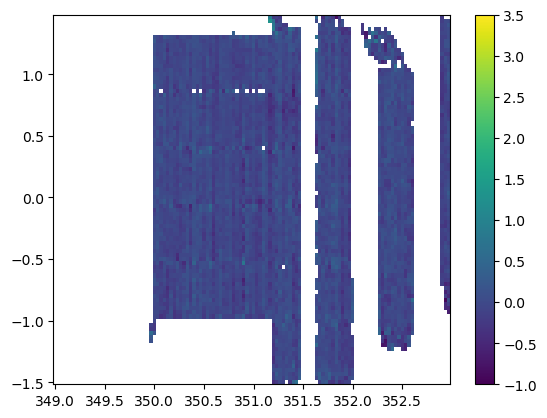

15 -175


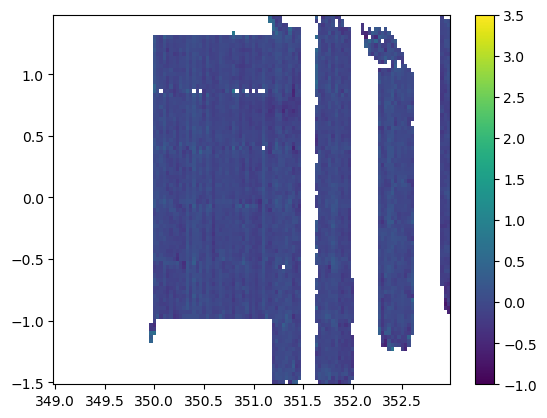

16 -170


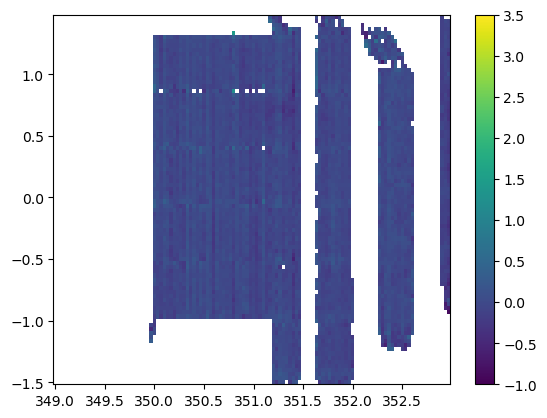

17 -165


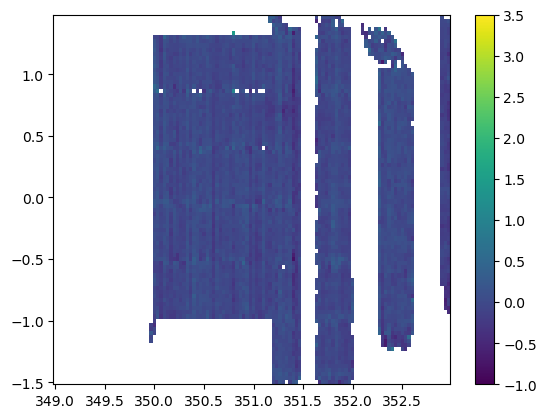

18 -160


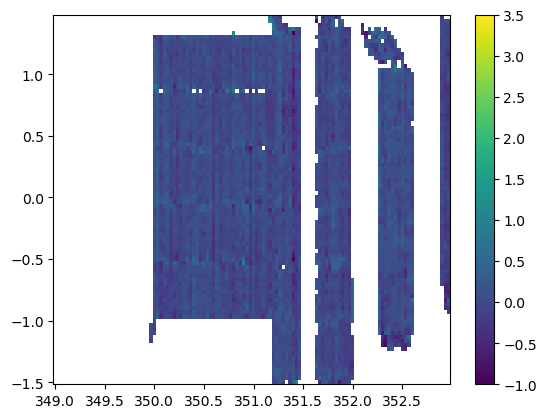

19 -155


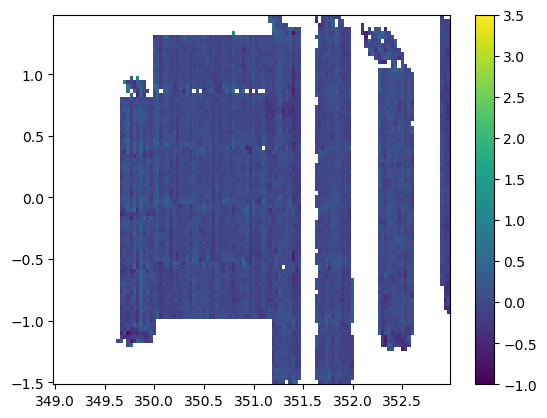

20 -150


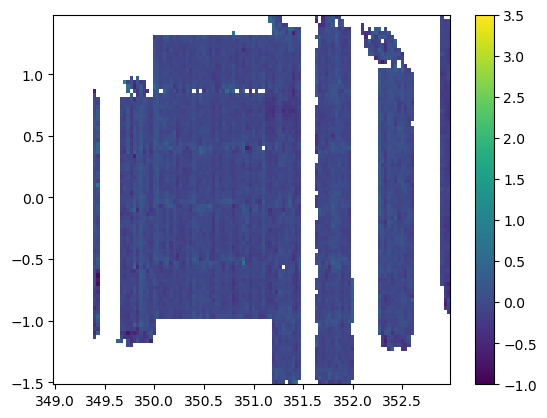

21 -145


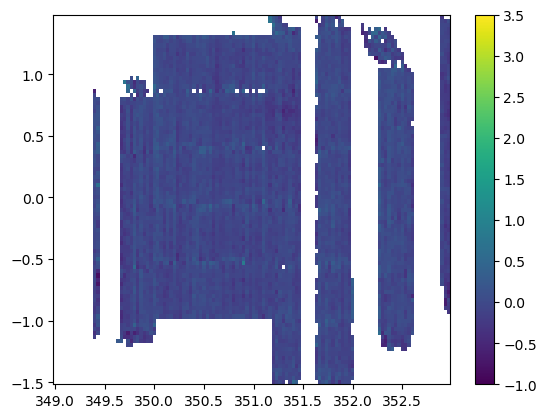

22 -140


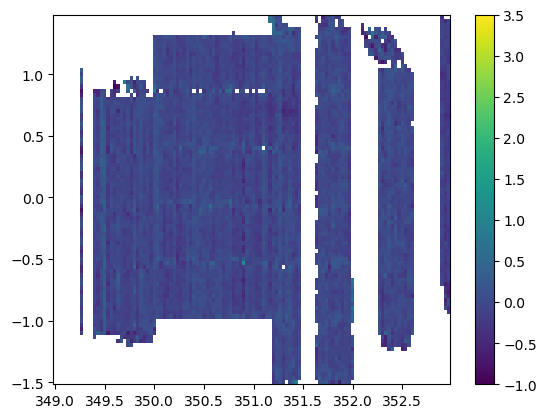

23 -135


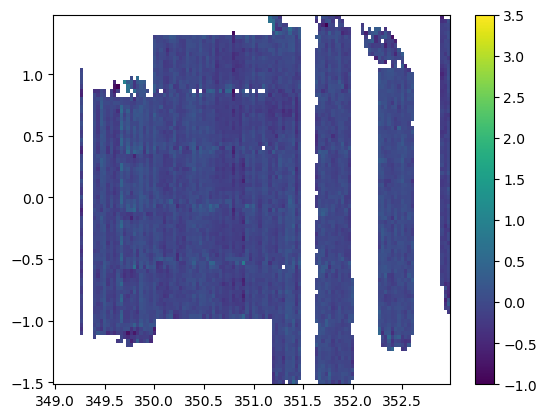

24 -130


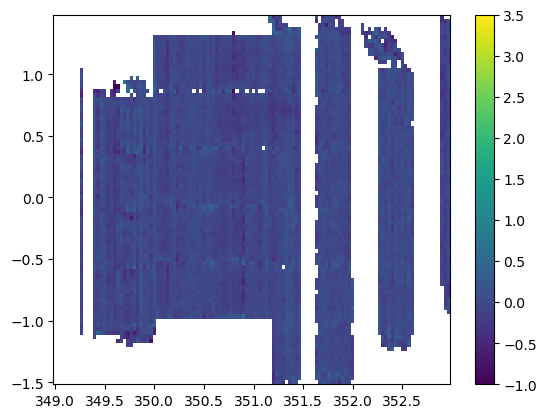

25 -125


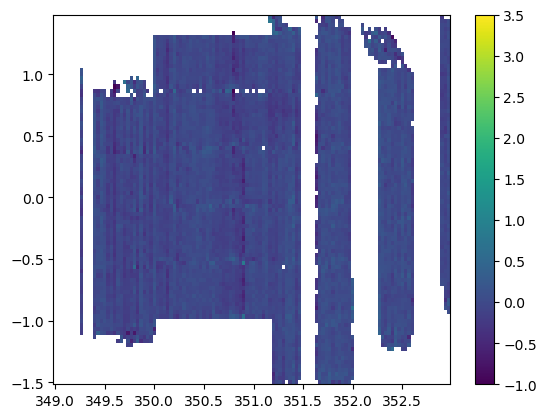

26 -120


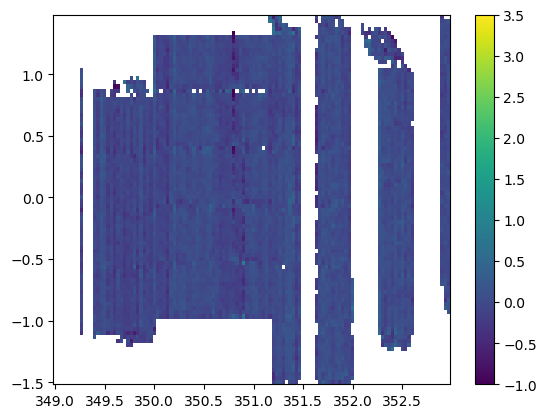

27 -115


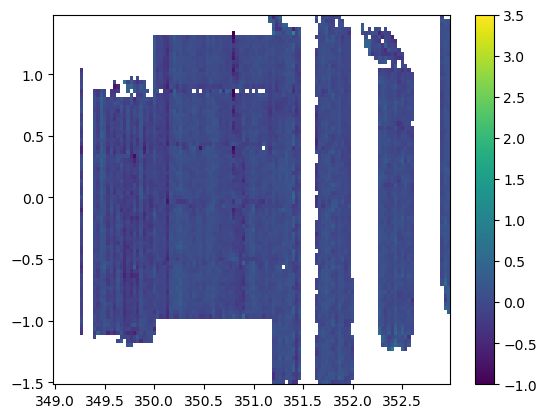

28 -110


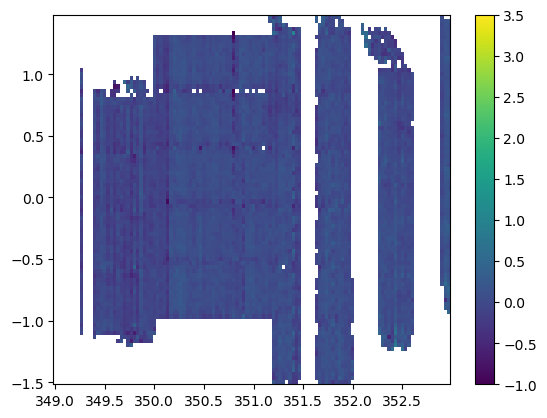

29 -105


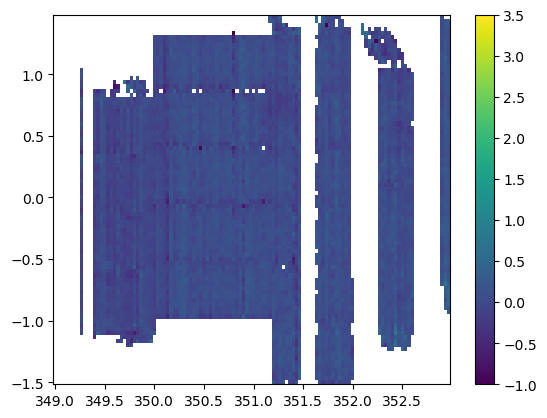

30 -100


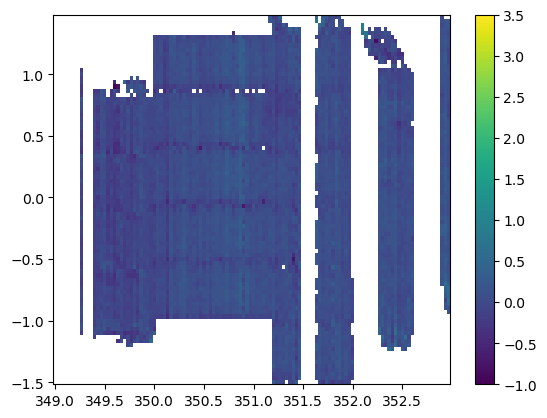

31 -95


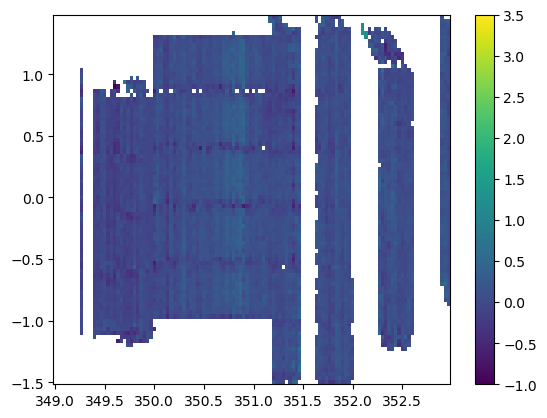

32 -90


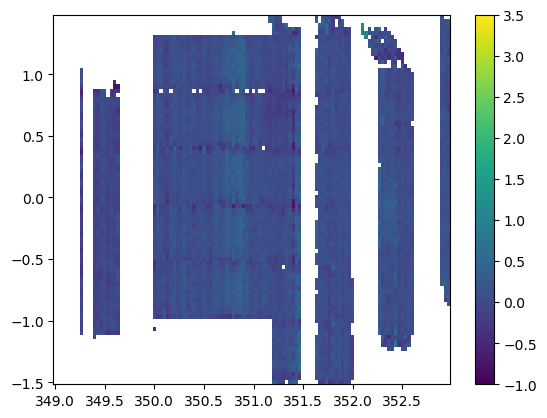

33 -85


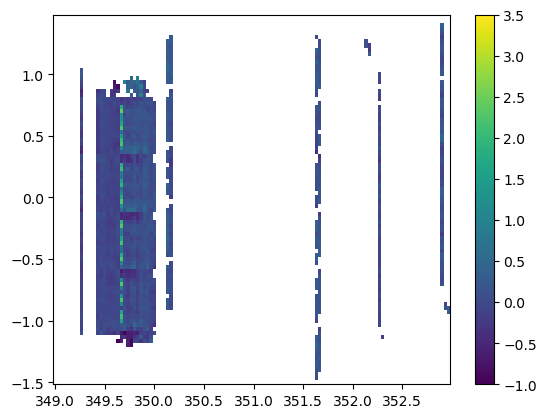

34 -80


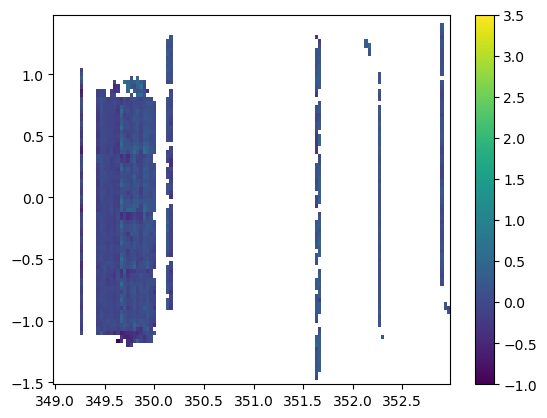

35 -75


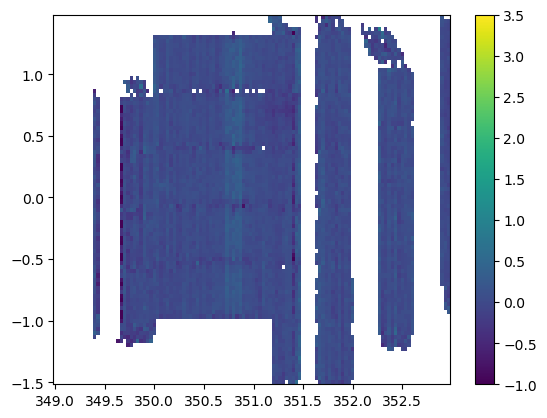

36 -70


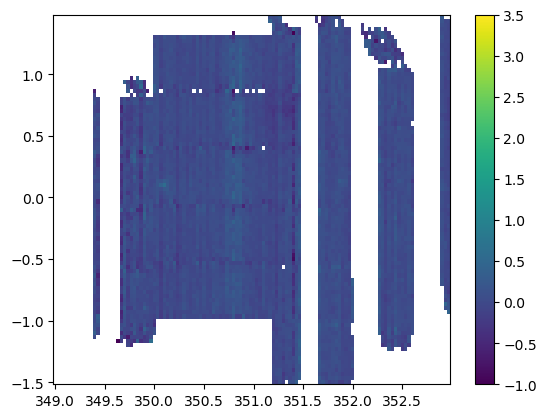

37 -65


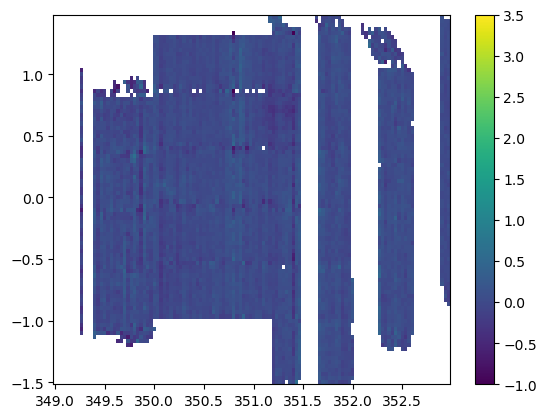

38 -60


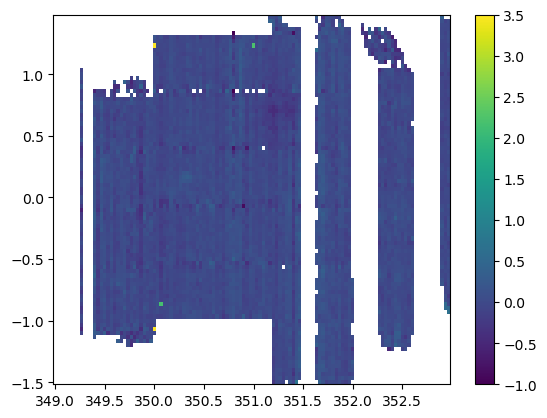

39 -55


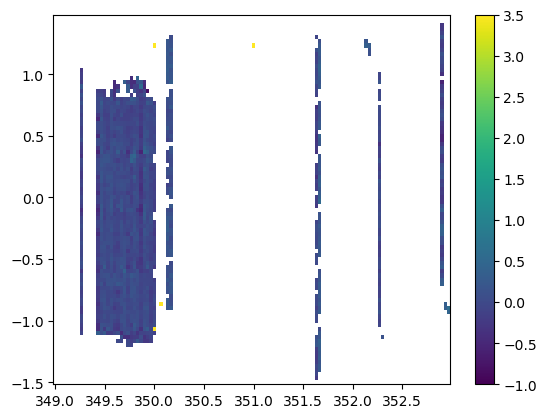

40 -50


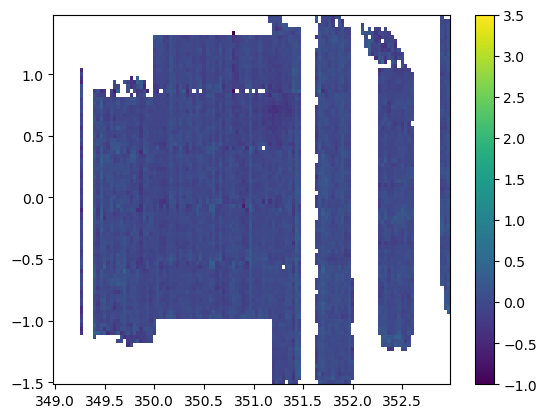

41 -45


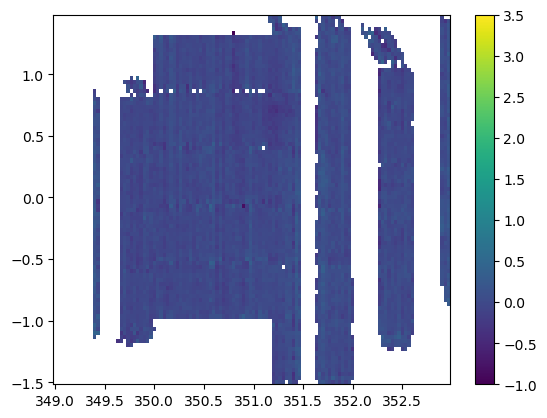

42 -40


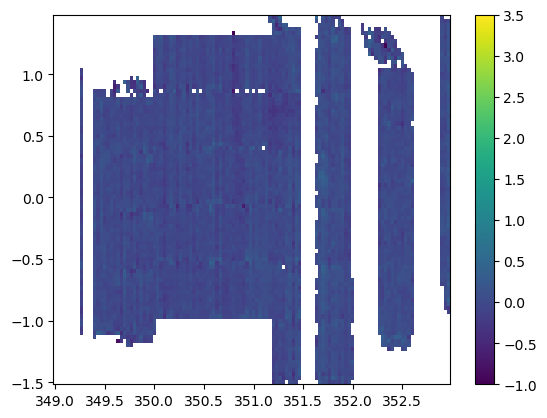

43 -35


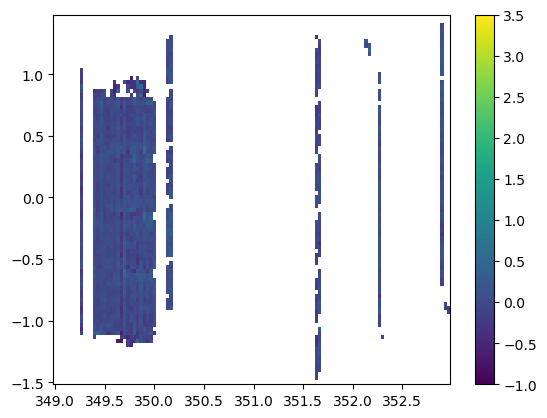

44 -30


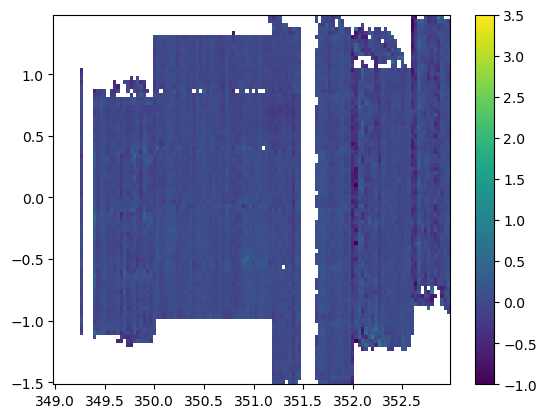

45 -25


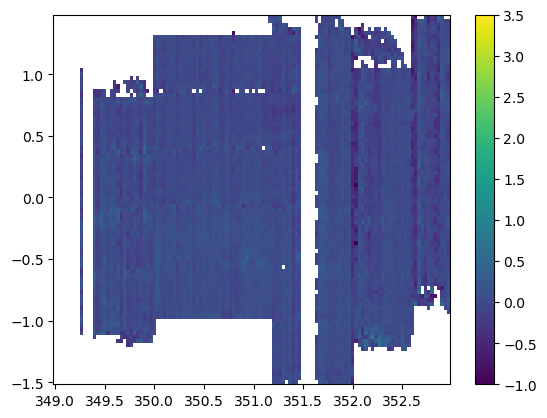

46 -20


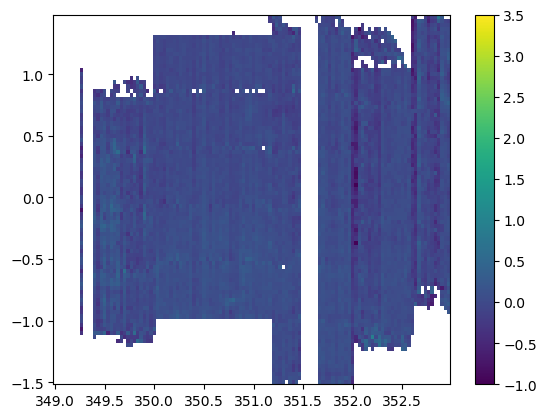

47 -15


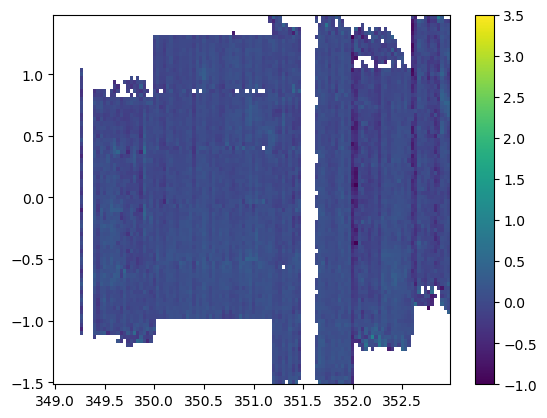

48 -10


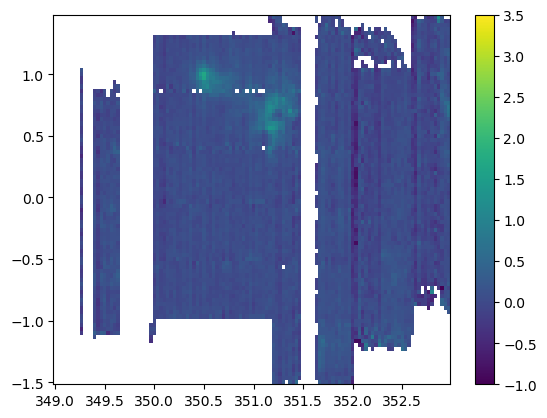

49 -5


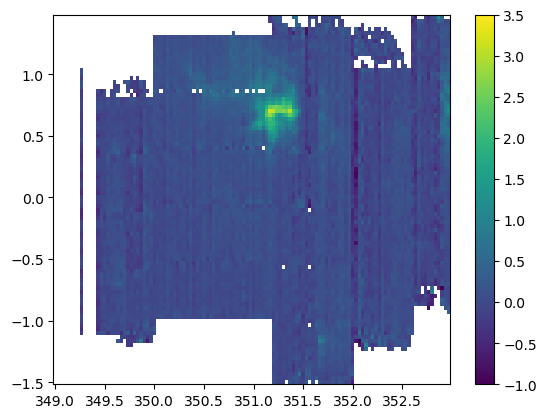

50 0


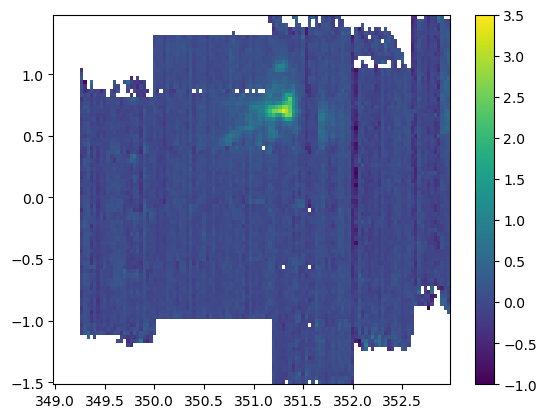

51 5


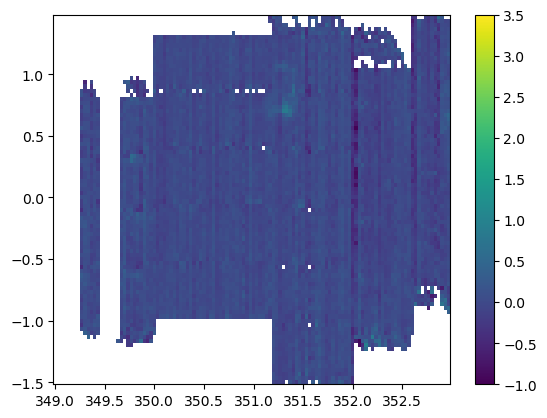

52 10


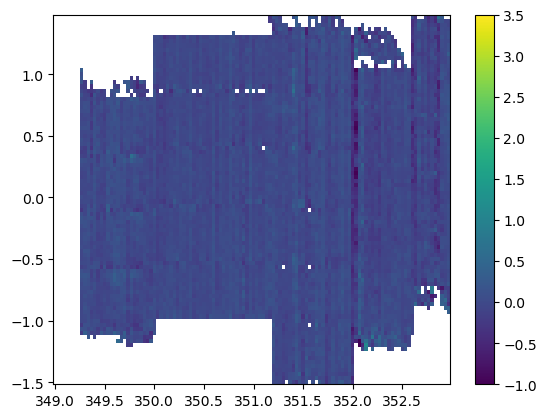

53 15


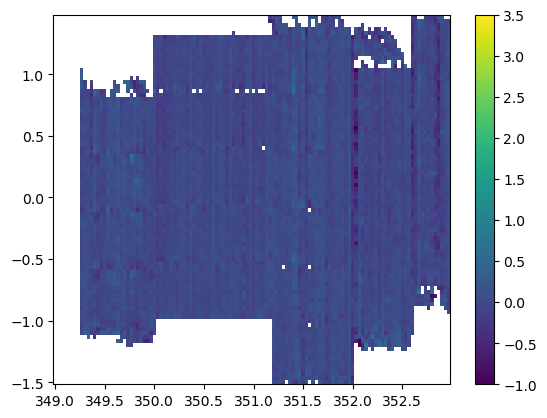

54 20


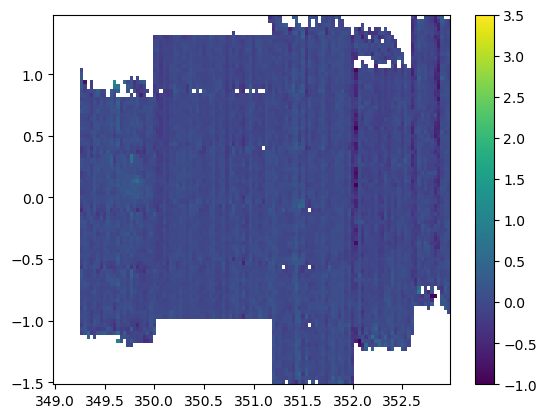

55 25


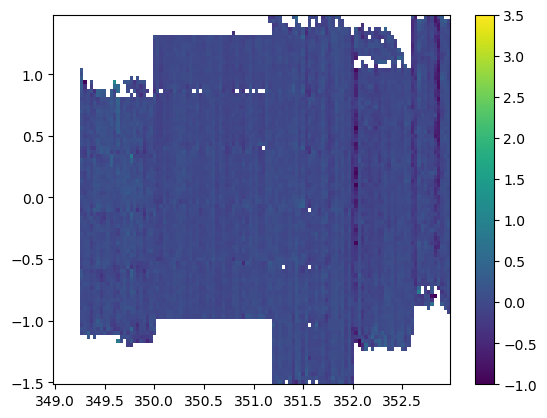

56 30


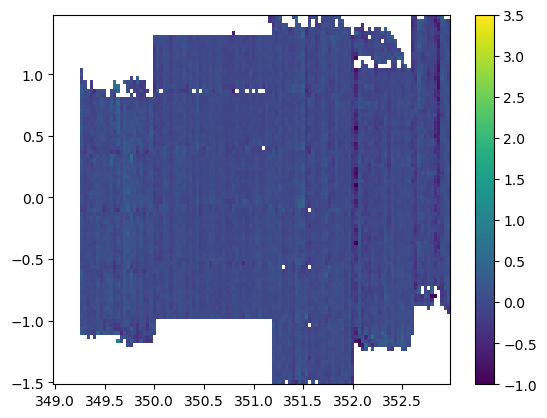

57 35


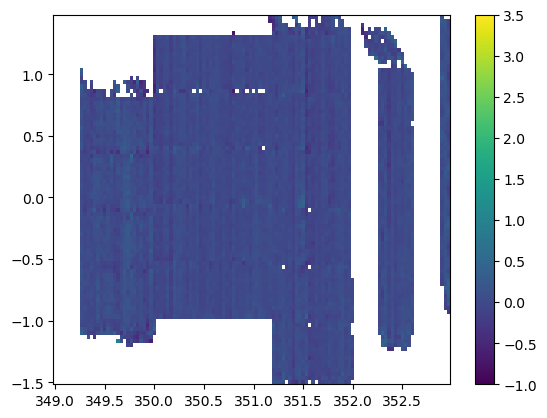

58 40


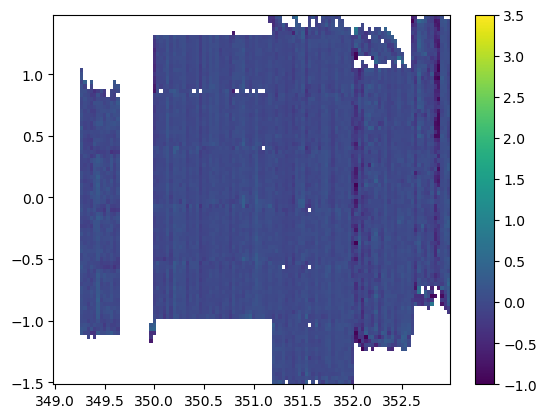

59 45


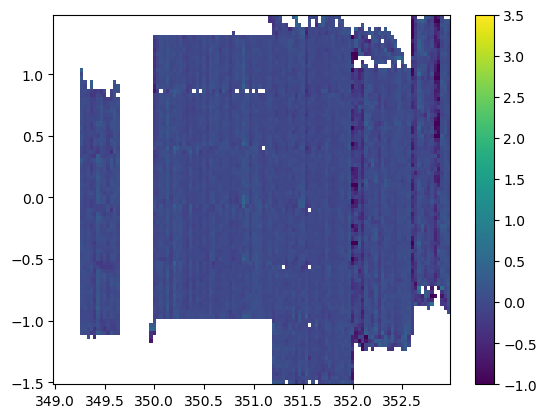

60 50


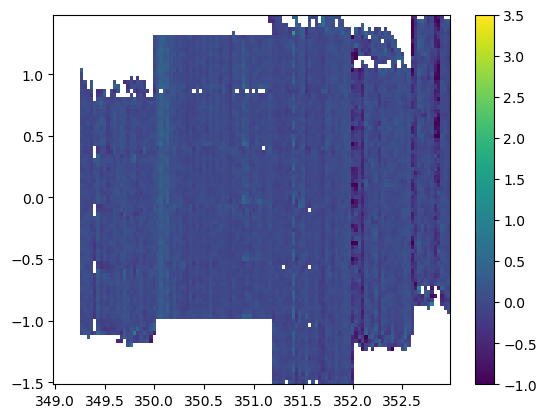

61 55


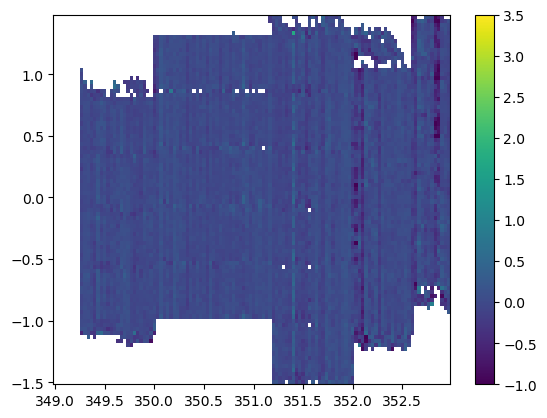

62 60


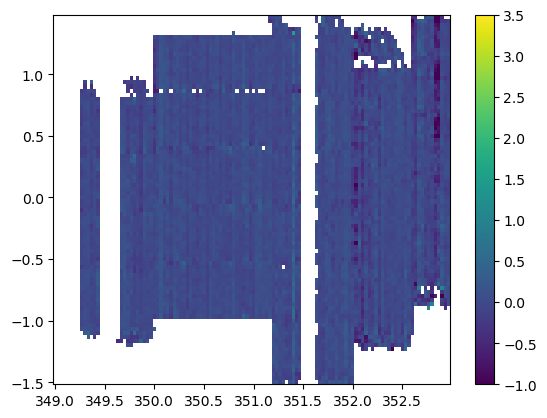

63 65


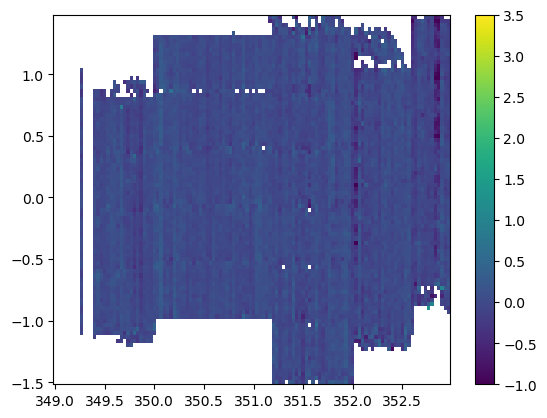

64 70


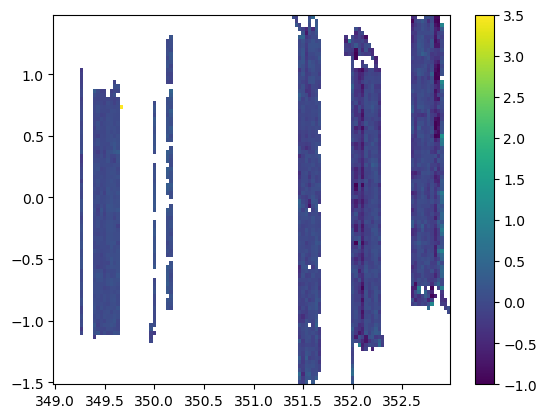

65 75


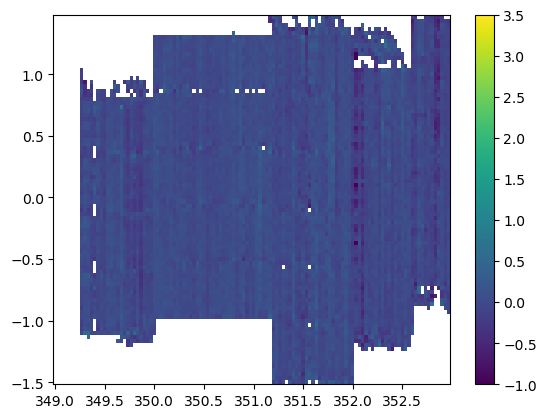

66 80


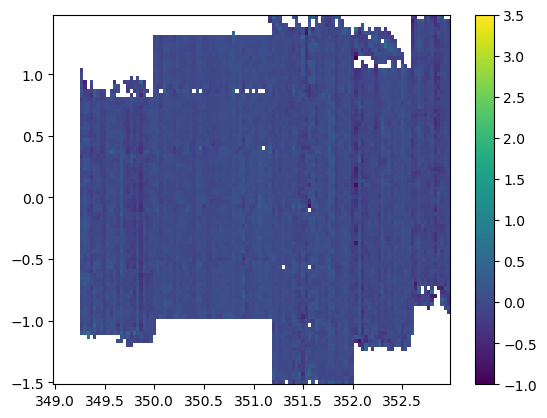

67 85


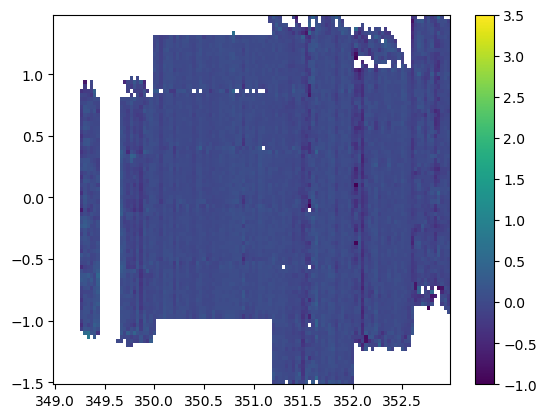

68 90


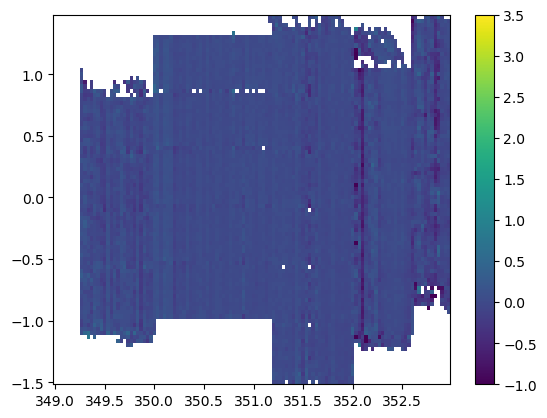

69 95


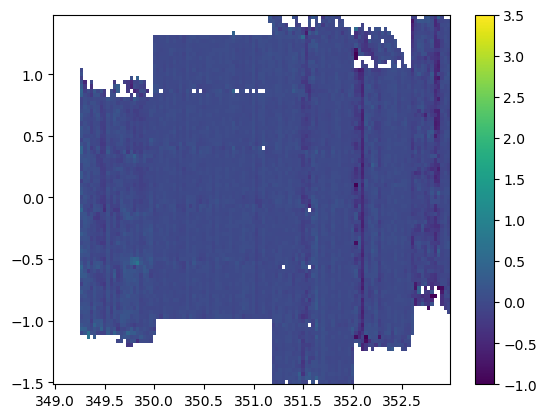

70 100


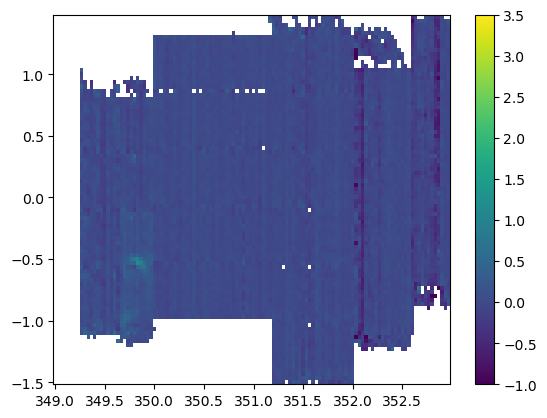

71 105


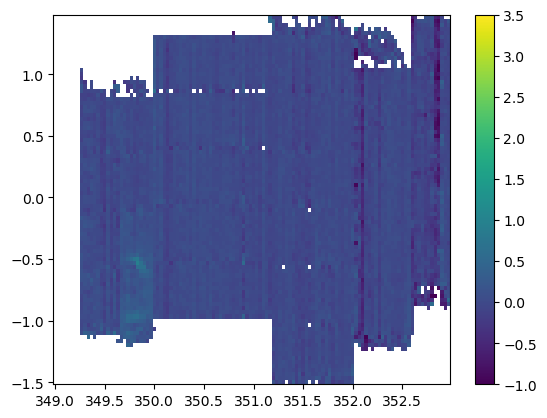

72 110


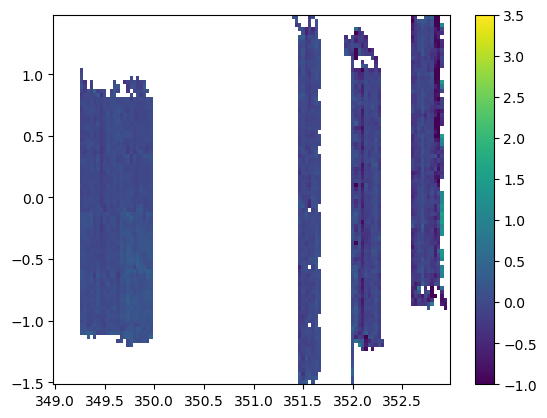

73 115


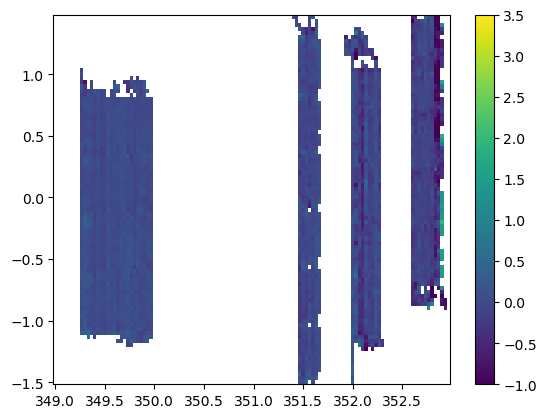

74 120


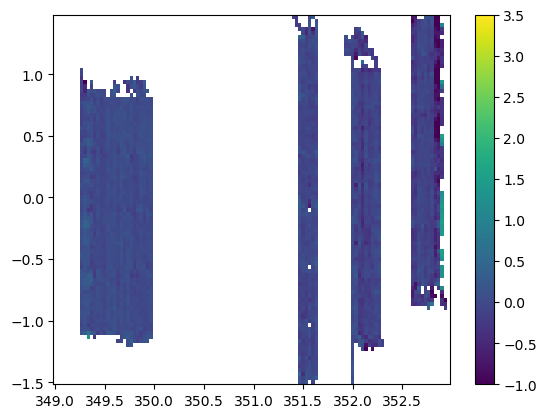

75 125


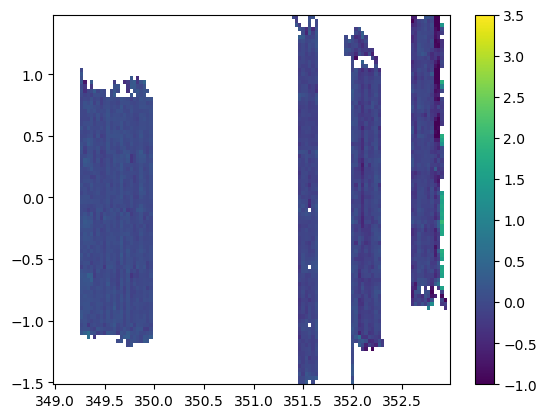

76 130


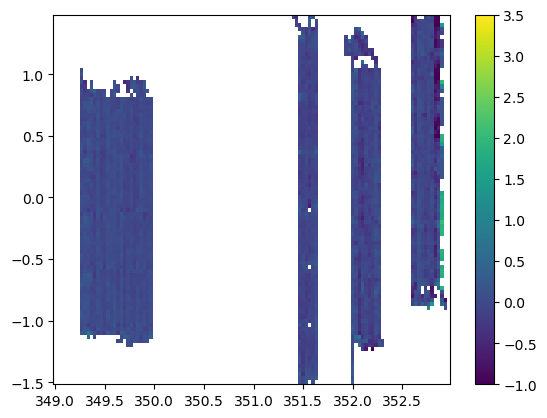

77 135


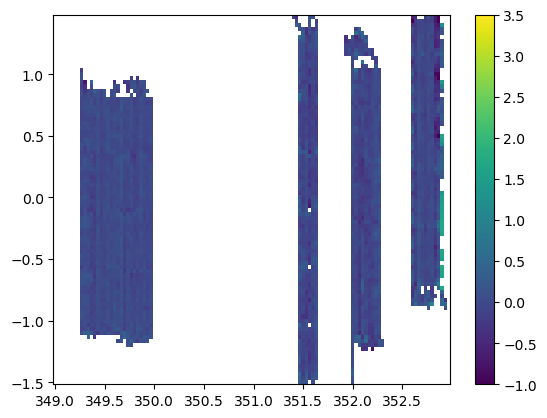

78 140


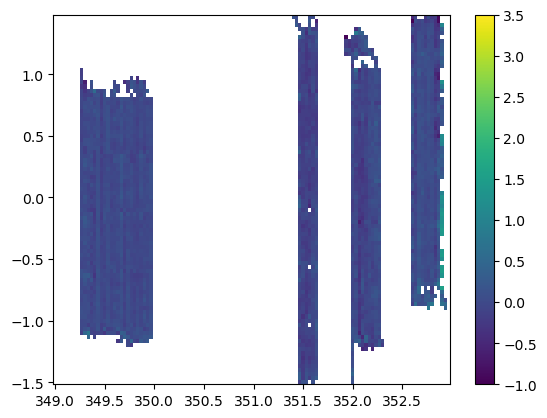

79 145


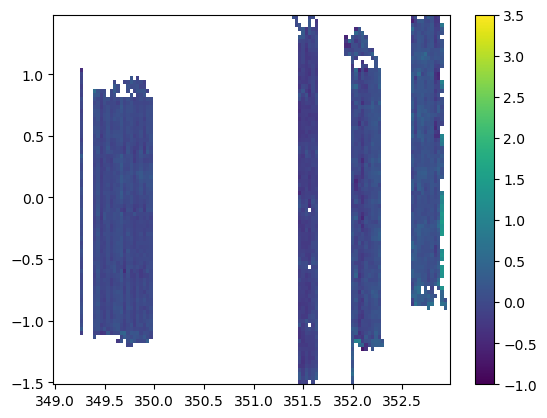

80 150


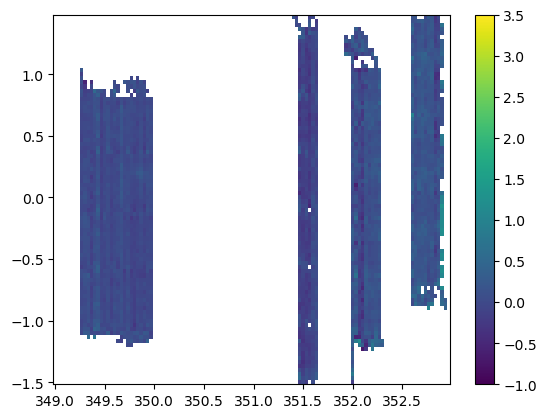

81 155


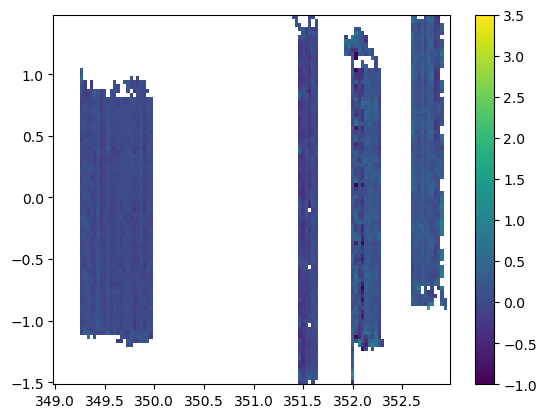

82 160


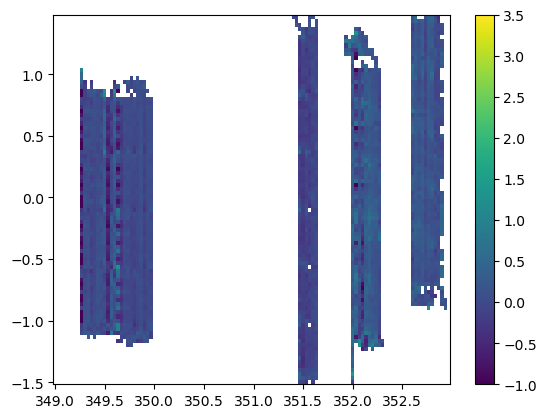

83 165


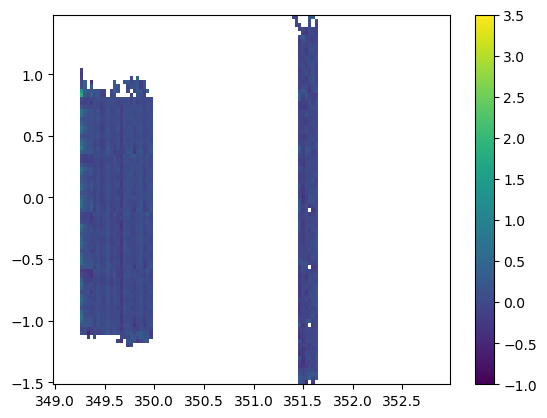

84 170


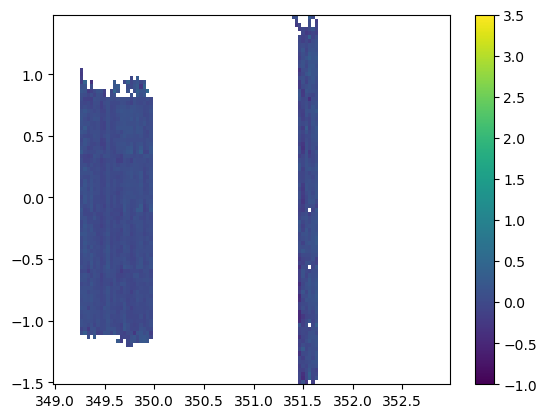

85 175


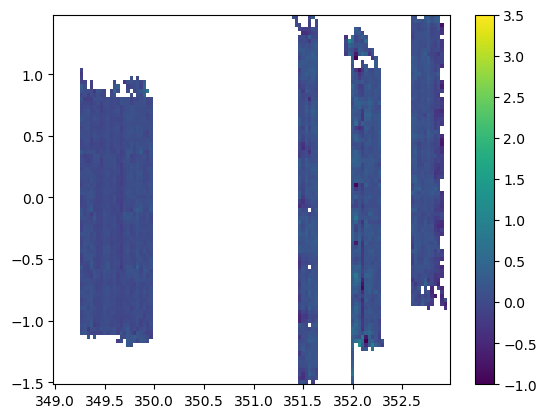

86 180


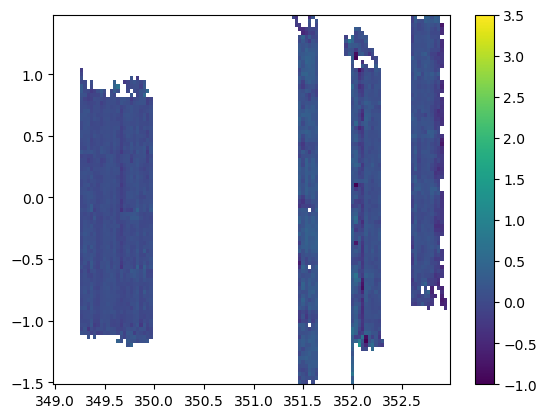

87 185


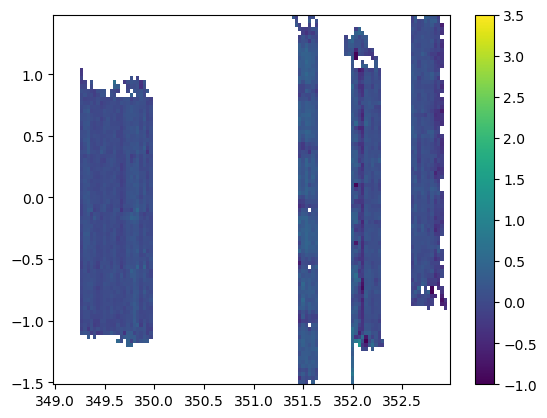

88 190


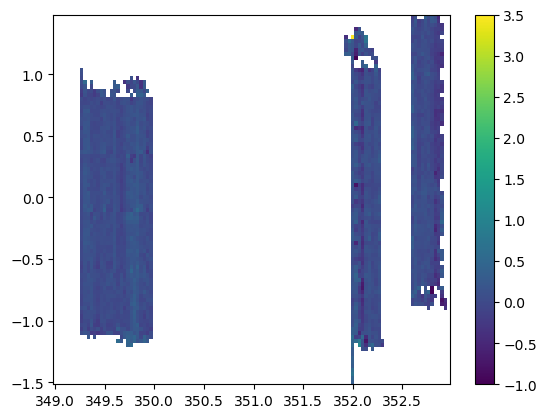

89 195


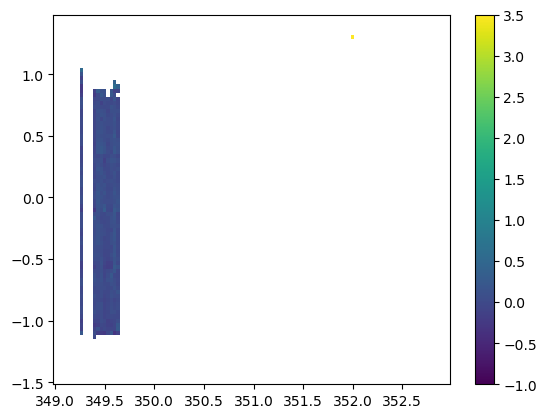

90 200


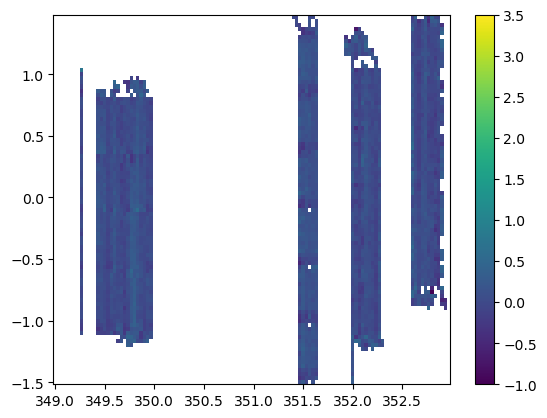

91 205


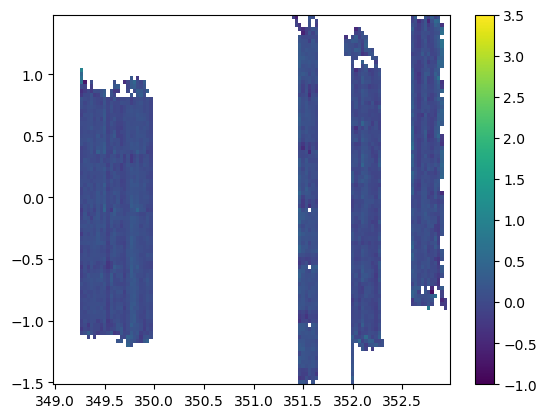

92 210


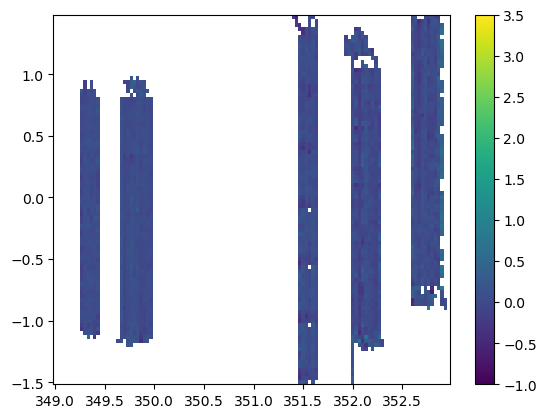

93 215


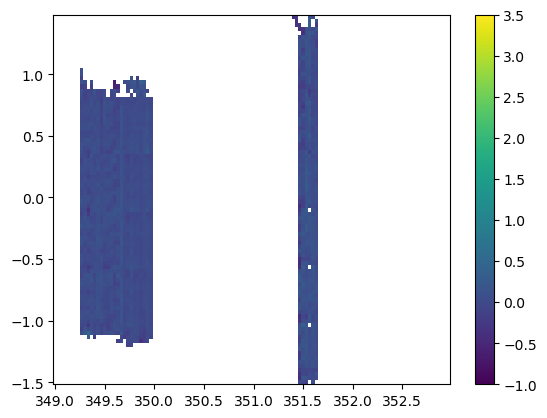

94 220


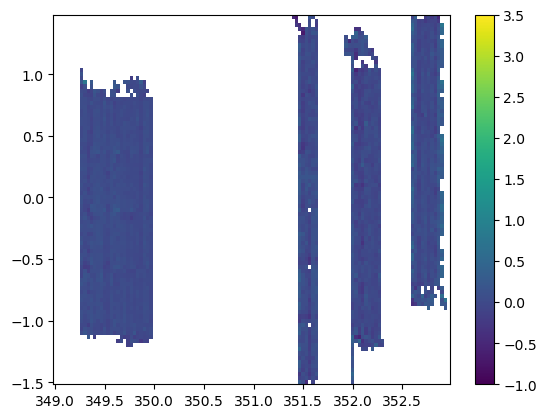

95 225


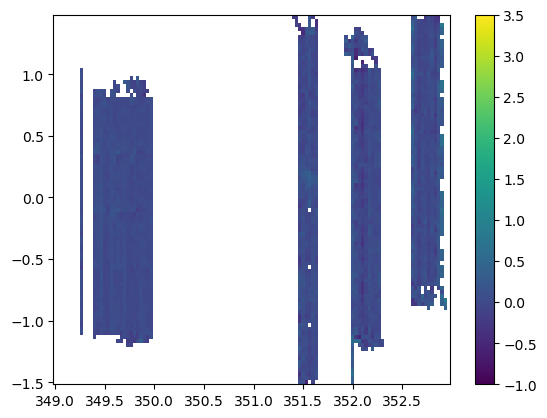

96 230


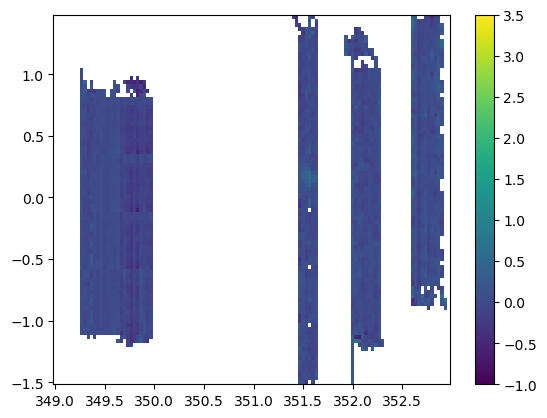

97 235


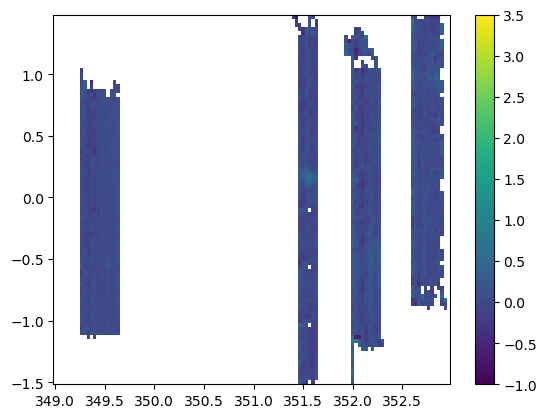

98 240


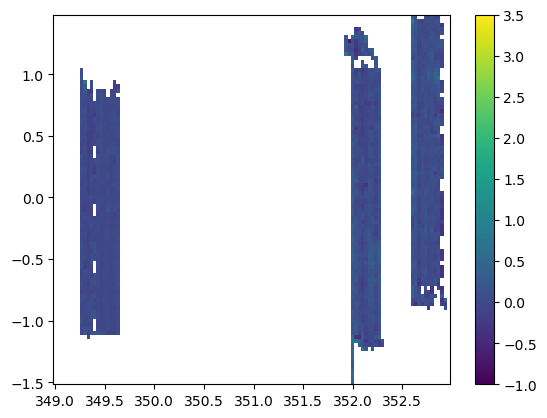

99 245


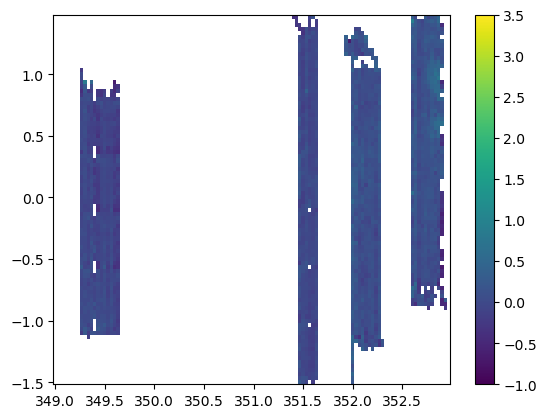

In [17]:
import time
intensity=intensity_sum/(count_sum*vel_spacing)
v_sel=70
fig, axs = plt.subplots(1,1)
print(intensity.shape,v_vector.shape,l_grid.shape,v_vector[v_sel])
plt.plot(v_vector[:],intensity[50,50,:])
print(l_grid[50,50,50],b_grid[50,50,50])
plt.show()
for idx in enumerate(v_vector):
    print(idx[0],v_vector[idx[0]])
    plt.clf()
    output = plt.pcolormesh(l_grid[:,:,1],b_grid[:,:,1],intensity[:,:,idx[0]],vmin=-1,vmax=3.5)
    plt.colorbar(output)
    plt.show()

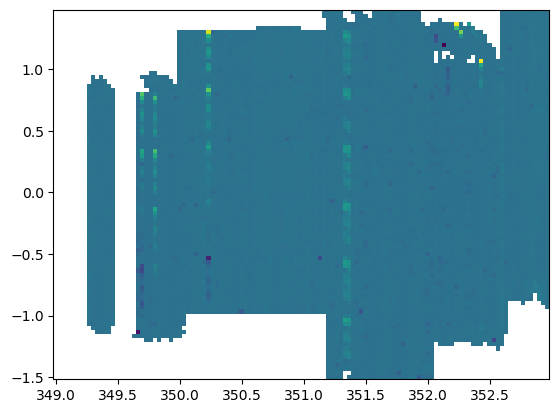

In [237]:
plt.pcolormesh(l_grid[:,:,1],b_grid[:,:,1],intensity[:,:,35])

In [57]:
vsearch = (v_vector >= vlsr-vel_spacing/2) & (v_vector < vlsr+vel_spacing/2)
print(v_vector[vsearch])

ValueError: operands could not be broadcast together with shapes (100,) (1024,) 

In [99]:
v_temp = np.broadcast_to(v_vector,(vlsr.size,v_vector.size))
vlsr_temp = np.transpose(np.broadcast_to(vlsr,(v_vector.size,vlsr.size)))
print(v_temp.shape)
print(vlsr_temp.shape)
test=(np.abs(v_temp-vlsr_temp)).argmin(axis=1)
print(test.shape)
print(test)
print(vlsr[test])

(1024, 100)
(1024, 100)
(1024,)
[99 99 99 ...  0  0  0]
[239.15558358 239.15558358 239.15558358 ... 315.48184329 315.48184329
 315.48184329]


In [115]:
temp = np.abs(vlsr - 95) <= vel_spacing/2
print(vlsr[temp])
print(spec_OTF[1,temp])
print(np.ma.count(spec_OTF[1,temp]))

[97.29667666 96.52570434 95.75473202 94.9837597  94.21278738 93.44181506
 92.67084273]
[-2.8565099239349365 -1.6189618110656738 -2.1739277839660645
 -3.019930362701416 -2.2515621185302734 -1.8440911769866943
 -2.5660712718963623]
7


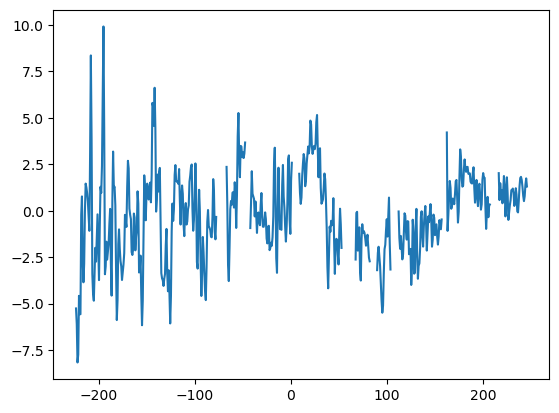

In [46]:
plt.plot(vlsr,spec_OTF[10])

In [55]:
spec_regrid_OTF = np.zeros((n_OTF,v_vector.size))
spec_regrid_OTF.shape

(967, 100)

In [28]:
96-64

32

In [30]:
0x60

96

In [35]:
(0x10)&(0x60)

0